In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Read Data

In [2]:
path = 'C:/Users/admicf/Documents/AppliedDeepLearningClass-master/exercises/ProyectoFinal/'

In [3]:
dataTraining = pd.read_csv(os.path.join(path, 'dataTraining.csv'), encoding='UTF-8', index_col=0)
dataTesting = pd.read_csv(os.path.join(path, 'dataTesting.csv'), encoding='UTF-8', index_col=0)

In [4]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


In [5]:
dataTesting.head()

,year,title,plot
1,1999,Message in a Bottle,"who meets by fate , shall be sealed by fate ...."
4,1978,Midnight Express,"the true story of billy hayes , an american c..."
5,1996,Primal Fear,martin vail left the chicago da ' s office to ...
6,1950,Crisis,husband and wife americans dr . eugene and mr...
7,1959,The Tingler,the coroner and scientist dr . warren chapin ...


# Create count vectorizer with ngrams

In [6]:
vect = CountVectorizer(ngram_range=(1, 2), max_features=1000,lowercase=False, min_df=2)
X_dtm = vect.fit_transform(dataTraining['plot'])
X_dtm.shape

(7895, 1000)

In [7]:
print(vect.get_feature_names()[:50])

['able', 'able to', 'about', 'about the', 'about to', 'accident', 'across', 'act', 'action', 'actually', 'affair', 'after', 'after the', 'again', 'against', 'against the', 'age', 'agent', 'ago', 'alex', 'alive', 'all', 'all of', 'all the', 'alone', 'along', 'along the', 'along with', 'already', 'also', 'although', 'always', 'america', 'american', 'among', 'an', 'an old', 'and', 'and has', 'and he', 'and her', 'and his', 'and is', 'and she', 'and that', 'and the', 'and their', 'and then', 'and they', 'and when']


# Create y

In [8]:
dataTraining['genres'] = dataTraining['genres'].map(lambda x: eval(x))

le = MultiLabelBinarizer()
y_genres = le.fit_transform(dataTraining['genres'])

# Split train and test

In [9]:
X_train, X_test, y_train_genres, y_test_genres = train_test_split(X_dtm, y_genres, test_size=0.33, random_state=42)

In [10]:
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import History
from livelossplot import PlotLossesKeras

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
model = Sequential()
model.add(Dense(128, input_shape=(1000,)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(24))
model.add(Activation('softmax'))
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_1 (Dense)                (None, 128)                 128128     
______________________________________________________________________
activation_1 (Activation)      (None, 128)                 0          
______________________________________________________________________
batch_normalization_1 (BatchNo (None, 128)                 512        
______________________________________________________________________
dropout_1 (Dropout)            (None, 128)                 0          
______________________________________________________________________
dense_2 (Dense)                (None, 24)                  3096       
______________________________________________________________________
activation_2 (Activation)      (None, 24)                  0          
Total params: 131,736
Trainable params: 131,480
Non-trainable params: 256
___

In [12]:
from keras.optimizers import SGD, RMSprop
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
              metrics = ['accuracy'], )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               128128    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
activation_2 (Activation)    (None, 24)                0         
Total params: 131,736
Trainable params: 131,480
Non-trainable params: 256
_________________________________________________________________


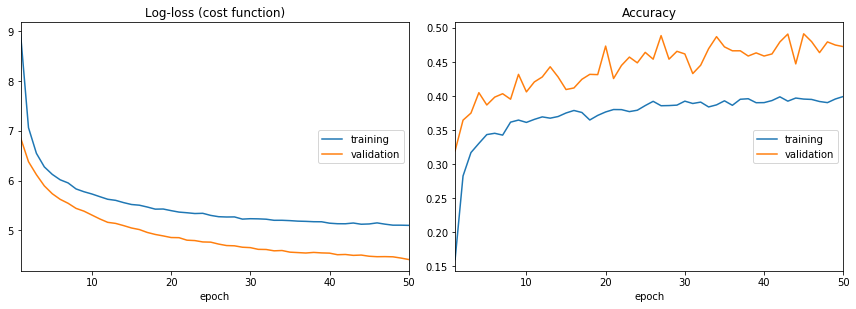

In [13]:
batch_size = 32
epochs = 50
history = model.fit(X_dtm, y_genres,validation_data=[X_test, y_test_genres],
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[PlotLossesKeras()])

In [20]:
model.save('model_text_nn.h5')
#model = load_model('model_rn1.h5')

In [14]:
score = model.evaluate(X_dtm, y_genres)
print('Test score:', score[0])
print('Test accuracy:', score[1])

7895/7895 [==============================] - 0s 46us/step
Test score: 4.385651105683842
Test accuracy: 0.464217859393362


In [15]:
y_pred_genres = model.predict_proba(X_test)

In [18]:
roc_auc_score(y_test_genres, y_pred_genres, average='macro')

0.9833695882142464

# Apply models to kaggle test

In [19]:
X_test_dtm = vect.transform(dataTesting['plot'])

cols = ['p_Action', 'p_Adventure', 'p_Animation', 'p_Biography', 'p_Comedy', 'p_Crime', 'p_Documentary', 'p_Drama', 'p_Family',
        'p_Fantasy', 'p_Film-Noir', 'p_History', 'p_Horror', 'p_Music', 'p_Musical', 'p_Mystery', 'p_News', 'p_Romance',
        'p_Sci-Fi', 'p_Short', 'p_Sport', 'p_Thriller', 'p_War', 'p_Western']

y_pred_test_genres = model.predict_proba(X_test_dtm)

pd.DataFrame(y_pred_test_genres, index=dataTesting.index, columns=cols).to_csv('pred_genres_text_RF.csv', index_label='ID')